In [10]:
import casatools
import casatasks
import matplotlib.pyplot as plt
from eDisk_source_dict import source_dict
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
center_coord = source_dict[source]["radec"]
ms = casatools.ms()
tb = casatools.table()

path = "/works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/"
msfilenames = [path + "L1489IRS_{:s}_continuum_shift.ms".format(i) for i in ["SB1", "SB2", "SB3", "LB1", "LB2"]]
# msfilenames = [path + "L1489IRS_{:s}_selfcal_cont_shift.ms".format(i) for i in ["SB1"]]
# msfilename = "/works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SB1_continuum.ms"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pickle

with open(
    "/works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS.pickle", "rb"
) as f:
    data_params = pickle.load(f)


In [9]:
# shift to the common center
for i in data_params.keys():
    vis = path + "L1489IRS_{:s}_continuum.ms".format(i)
    casatasks.fixvis(
        vis=vis,
        outputvis=vis.replace(".ms", "_shift.ms"),
        field=source,
        phasecenter="J2000 " + data_params[i]["phasecenter"],
    )
    casatasks.fixplanets(
        vis=vis.replace(".ms", "_shift.ms"),
        field=source,
        direction="J2000 " + center_coord,
    )


2022-08-25 03:03:17	WARN	fixvis::::casa	**ALERT:** Deprecated in CASA 5.9/6.3. Please use task **phaseshift** instead.
2022-08-25 03:03:31	WARN	fixplanets::::casa	The three FIELD table direction reference frame entries for field 0 are not identical in the input data: 0, 21, 21. Will try to continue ...
2022-08-25 03:03:33	WARN	fixvis::::casa	**ALERT:** Deprecated in CASA 5.9/6.3. Please use task **phaseshift** instead.
2022-08-25 03:03:52	WARN	fixplanets::::casa	The three FIELD table direction reference frame entries for field 0 are not identical in the input data: 0, 21, 21. Will try to continue ...
2022-08-25 03:03:52	WARN	fixvis::::casa	**ALERT:** Deprecated in CASA 5.9/6.3. Please use task **phaseshift** instead.
2022-08-25 03:04:05	WARN	fixplanets::::casa	The three FIELD table direction reference frame entries for field 0 are not identical in the input data: 0, 21, 21. Will try to continue ...
2022-08-25 03:04:05	WARN	fixvis::::casa	**ALERT:** Deprecated in CASA 5.9/6.3. Please us

In [18]:
# split out the flagged data and bin onto one channel per spw
for i in data_params.keys():
    vis = path + "L1489IRS_{:s}_continuum_shift.ms".format(i)
    ms.open(vis)
    metadata = ms.metadata()
    width = [metadata.nchan(j) for j in metadata.spwfordatadesc()]
    ms.close()
    casatasks.split(
        vis=vis,
        outputvis=vis.replace(".ms", ".split.ms"),
        datacolumn="data",
        keepflags=False,
        width=width,
    )


In [36]:
from visibility import Visibility

msfilenames = [
    path + "L1489IRS_{:s}_continuum_shift.split.ms".format(i)
    for i in ["SB1", "SB2", "SB3", "LB1", "LB2"]
]
vis = Visibility(msfilenames)


Loading /works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SB1_continuum_shift.split.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SB2_continuum_shift.split.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SB3_continuum_shift.split.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_LB1_continuum_shift.split.ms...
Loading data in spw 0...
Loading data in sp

In [28]:
import numpy as np

n = vis.V.size
n * np.log10(n) / (16488914 * np.log10(16488914))


30.02931876685333

In [37]:
# vis.bin_2D(binsize=10e3)
vis.export_vis(filename="./L1489IRS_continuum_channelbin.npz")


In [30]:
vis.deproject(PA=PA, incl=incl)
r, v, err = vis.bin_1D(binsize=10e3)


Text(0, 0.5, 'Real [Jy]')

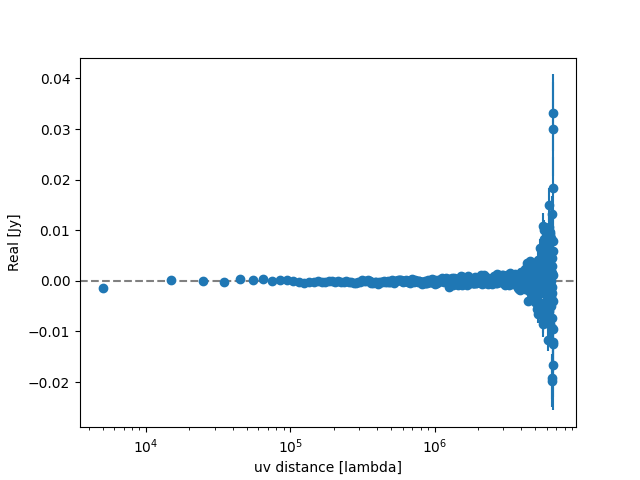

In [38]:
plt.figure()
plt.errorbar(r, v.imag, yerr=err, fmt="o")
plt.axhline(y=0.0, color="grey", ls="dashed")
plt.xscale("log")
plt.xlabel("uv distance [lambda]")
plt.ylabel("Real [Jy]")


In [34]:
binvis = Visibility("./L1489IRS_continuum_bin_10klambda.npz")
print(binvis.V.size)
binvis.deproject(PA=PA, incl=incl)
rbin, vbin, errbin = binvis.bin_1D(binsize=10e3)


2122849


/home/yamato/Project/eDisk/firstlook_L1489IRS/visibility.py:36: RuntimeWarning: invalid value encountered in true_divide
  return vw / w
/home/yamato/Project/eDisk/firstlook_L1489IRS/visibility.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / np.sqrt(np.nansum(x))


Text(0, 0.5, 'Real [Jy]')

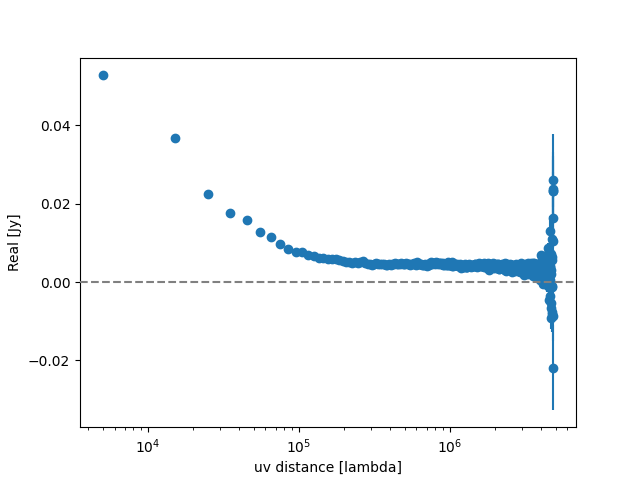

In [35]:
plt.figure()
plt.errorbar(rbin, vbin.real, yerr=errbin, fmt="o")
plt.axhline(y=0.00, color="grey", ls="dashed", zorder=100)
plt.xscale("log")
plt.xlabel("uv distance [lambda]")
plt.ylabel("Real [Jy]")

In [20]:
import numpy as np

np.max(vis.uvdist)


2130739.7605331475

In [12]:
ms.open(vis.filenames[0])
# ms.selectinit(datadescid=0)
ms.getfielddirmeas(format="measure")

metadata = ms.metadata()
metadata.phasecenter()
from astropy.coordinates import SkyCoord
import astropy.units as u

c = SkyCoord(ra=1.06776 * u.rad, dec=0.4592945 * u.rad, frame="icrs")
c.to_string("hmsdms")


'04h04m42.75396789s +26d18m56.29105286s'

In [69]:
ms.open(msfilename)
import numpy as np

ms.selectinit(datadescid=4)
data = ms.getdata(["flag", "data", "weight", "u"])
print(data["weight"].shape)
np.where(data["flag"] == False)


(2, 227010)


(array([0, 0, 0, ..., 1, 1, 1]),
 array([ 0,  0,  0, ..., 63, 63, 63]),
 array([    46,     47,     48, ..., 162147, 162148, 162149]))

In [65]:
ms.getdata(["axis_info"])


{'axis_info': {'corr_axis': array(['XX', 'YY'], dtype='<U16'),
  'freq_axis': {'chan_freq': array([[2.18659277e+11],
          [2.18629980e+11],
          [2.18600683e+11],
          [2.18571386e+11],
          [2.18542089e+11],
          [2.18512792e+11],
          [2.18483496e+11],
          [2.18454199e+11],
          [2.18424902e+11],
          [2.18395605e+11],
          [2.18366308e+11],
          [2.18337011e+11],
          [2.18307714e+11],
          [2.18278417e+11],
          [2.18249121e+11],
          [2.18219824e+11],
          [2.18190527e+11],
          [2.18161230e+11],
          [2.18131933e+11],
          [2.18102636e+11],
          [2.18073339e+11],
          [2.18044042e+11],
          [2.18014746e+11],
          [2.17985449e+11],
          [2.17956152e+11],
          [2.17926855e+11],
          [2.17897558e+11],
          [2.17868261e+11],
          [2.17838964e+11],
          [2.17809667e+11],
          [2.17780371e+11],
          [2.17751074e+11],
          [2.17

In [66]:
ms.getspectralwindowinfo()


{'4': {'Chan1Freq': 218659276824.83282,
  'ChanWidth': -29296875.0,
  'Frame': 'TOPO',
  'NumChan': 64,
  'NumCorr': 2,
  'PolId': 0,
  'RefFreq': 216813573699.83282,
  'SpectralWindowId': 4,
  'TotalWidth': 1875000000.0}}

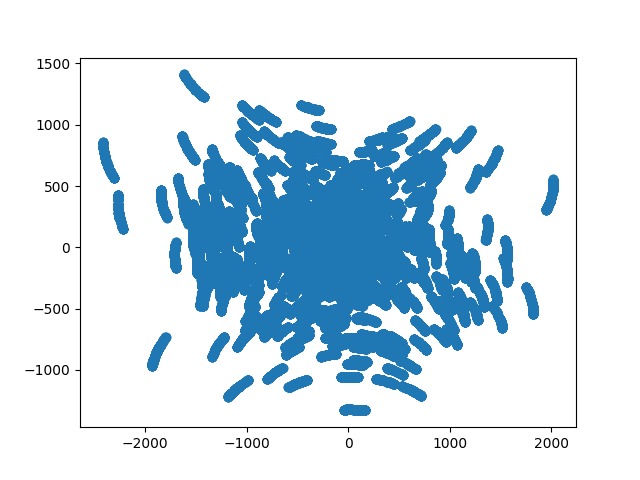

In [19]:
plt.scatter(data["u"], data["v"])
